# Baseball Pitch Prediction - Model Evaluation

This notebook evaluates the performance of our trained models and analyzes their predictions.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import roc_curve, auc, confusion_matrix
import shap

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

## 1. Load Model Results

In [2]:
# Load model comparison results
results = pd.read_csv('../models/results/model_comparison.csv')

# Display results table
print("Model Performance Comparison:")
results.style.format({
    'Accuracy': '{:.3f}',
    'Precision': '{:.3f}',
    'Recall': '{:.3f}',
    'F1 Score': '{:.3f}',
    'ROC AUC': '{:.3f}'
})

Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.639,0.656,0.736,0.694,0.693
1,Decision Tree,0.718,0.725,0.794,0.758,0.801
2,Random Forest,0.723,0.734,0.787,0.760,0.808
3,XGBoost,0.730,0.739,0.797,0.767,0.819


## 2. Model Performance Visualization

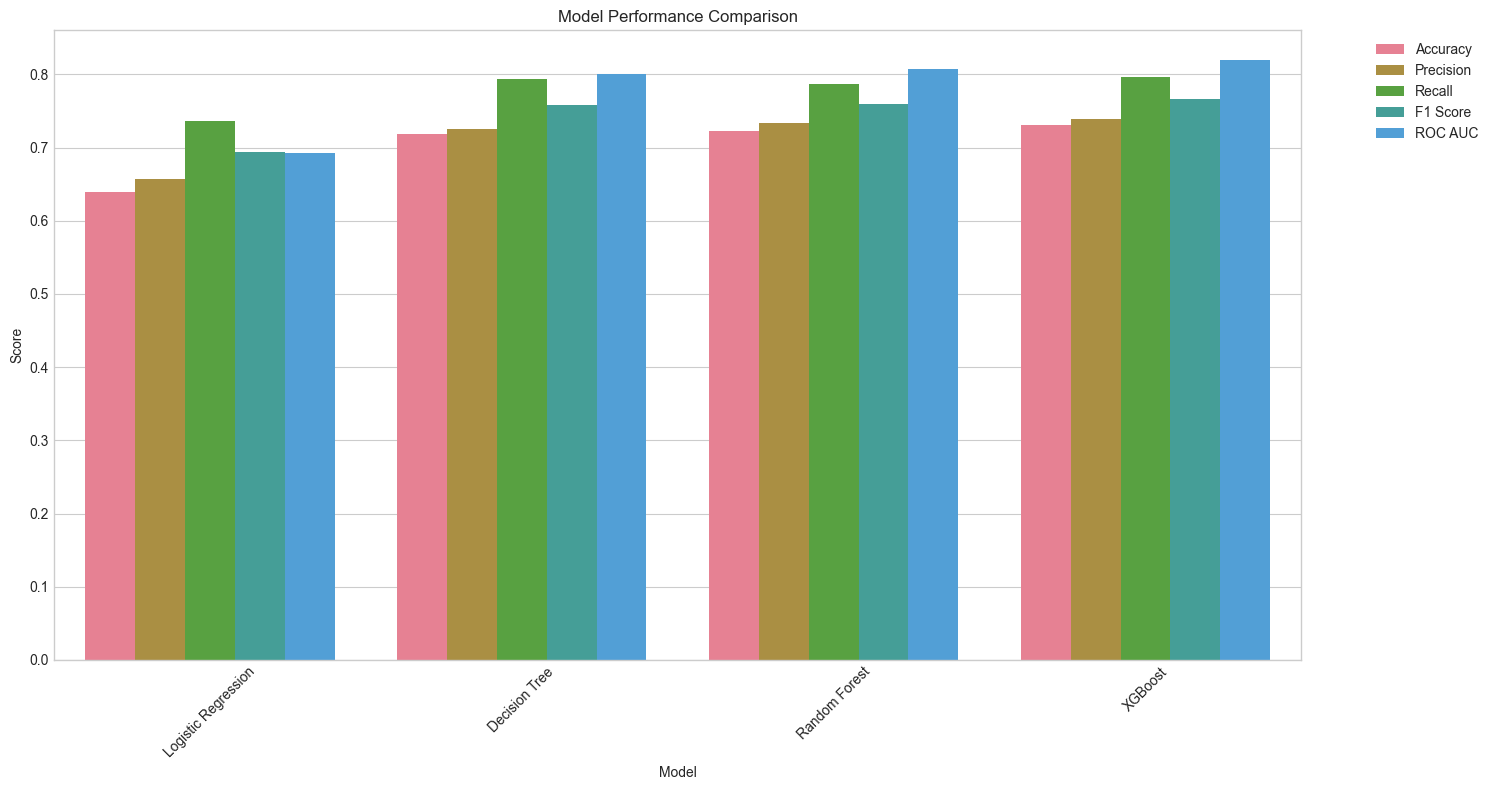

In [3]:
# Create bar plot comparing model metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
results_melted = pd.melt(results, id_vars=['Model'], value_vars=metrics, var_name='Metric', value_name='Score')

plt.figure(figsize=(15, 8))
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

## 3. Confusion Matrix Analysis

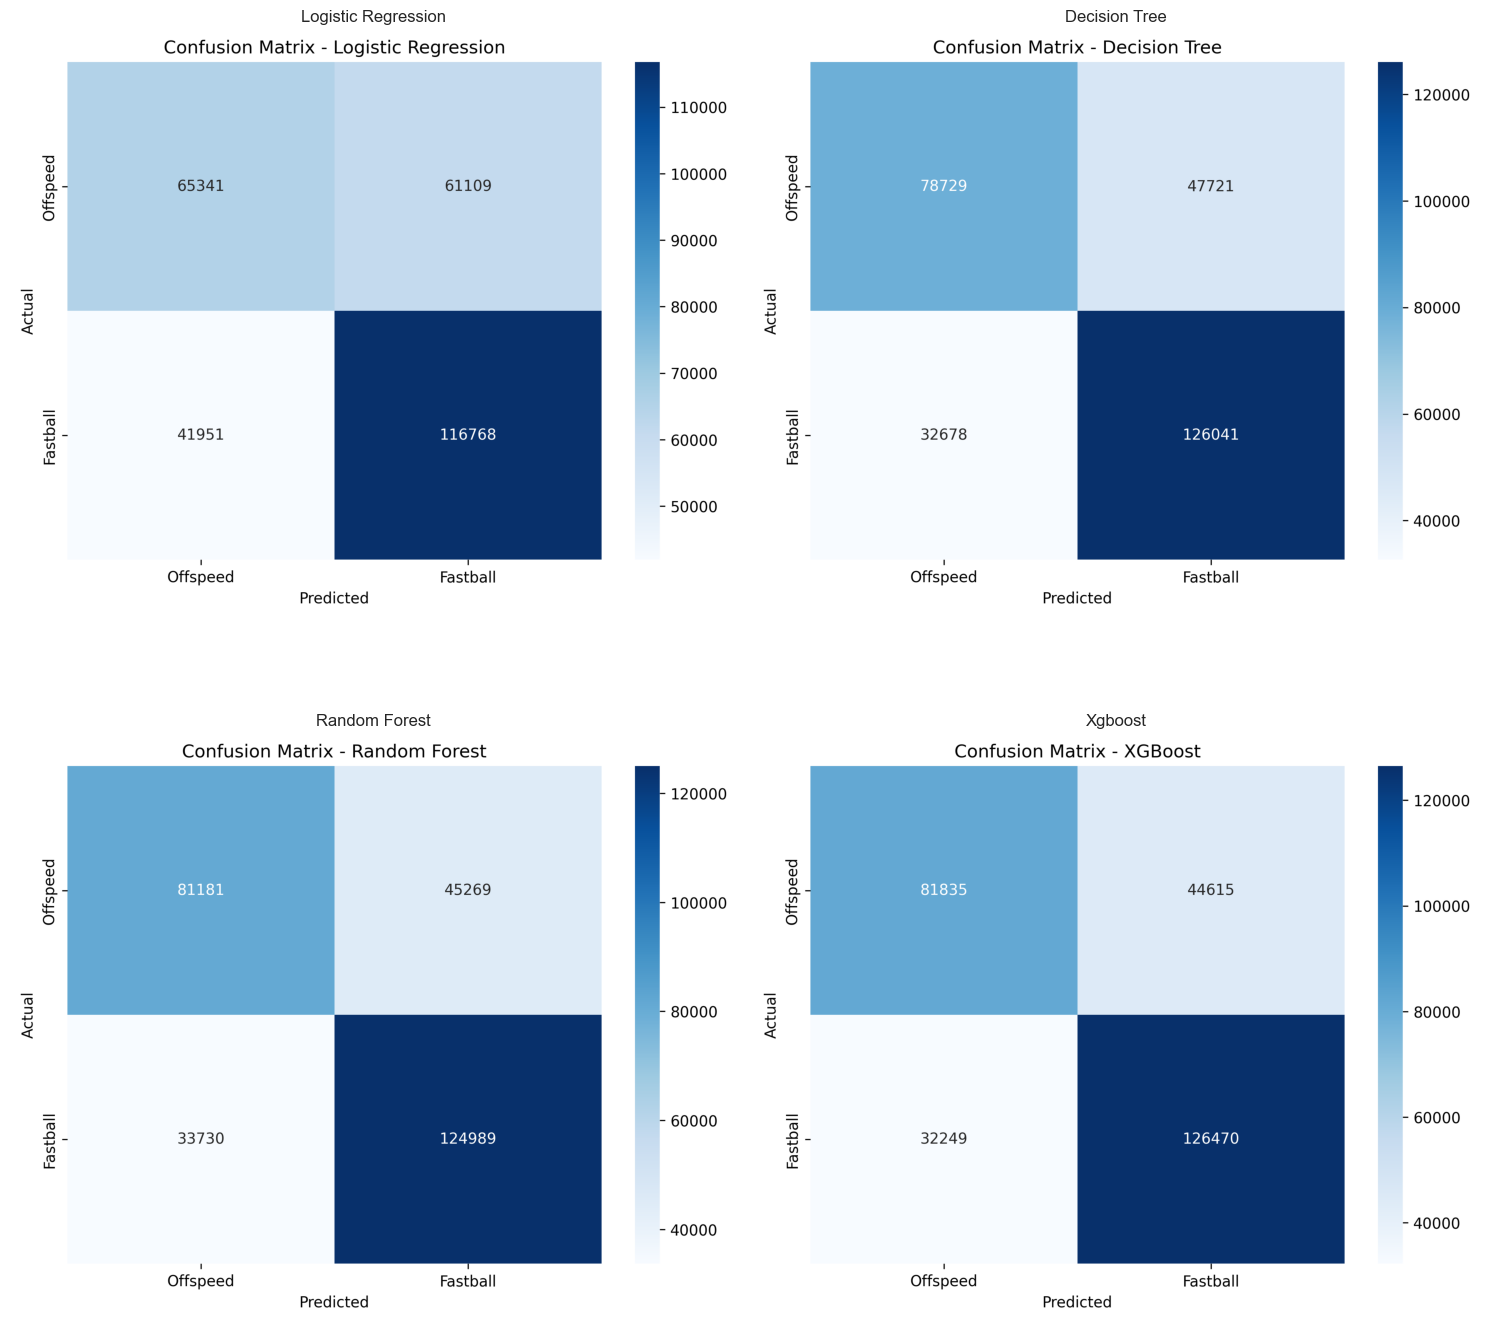

In [5]:
# Load and display confusion matrices
import matplotlib.image as mpimg

models = ['logistic_regression', 'decision_tree', 'random_forest', 'xgboost']

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for i, model in enumerate(models):
    img = mpimg.imread(f'../models/results/{model}_confusion_matrix.png')
    ax = axes[i//2, i%2]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(model.replace('_', ' ').title())
plt.tight_layout()

## 4. Feature Importance Analysis

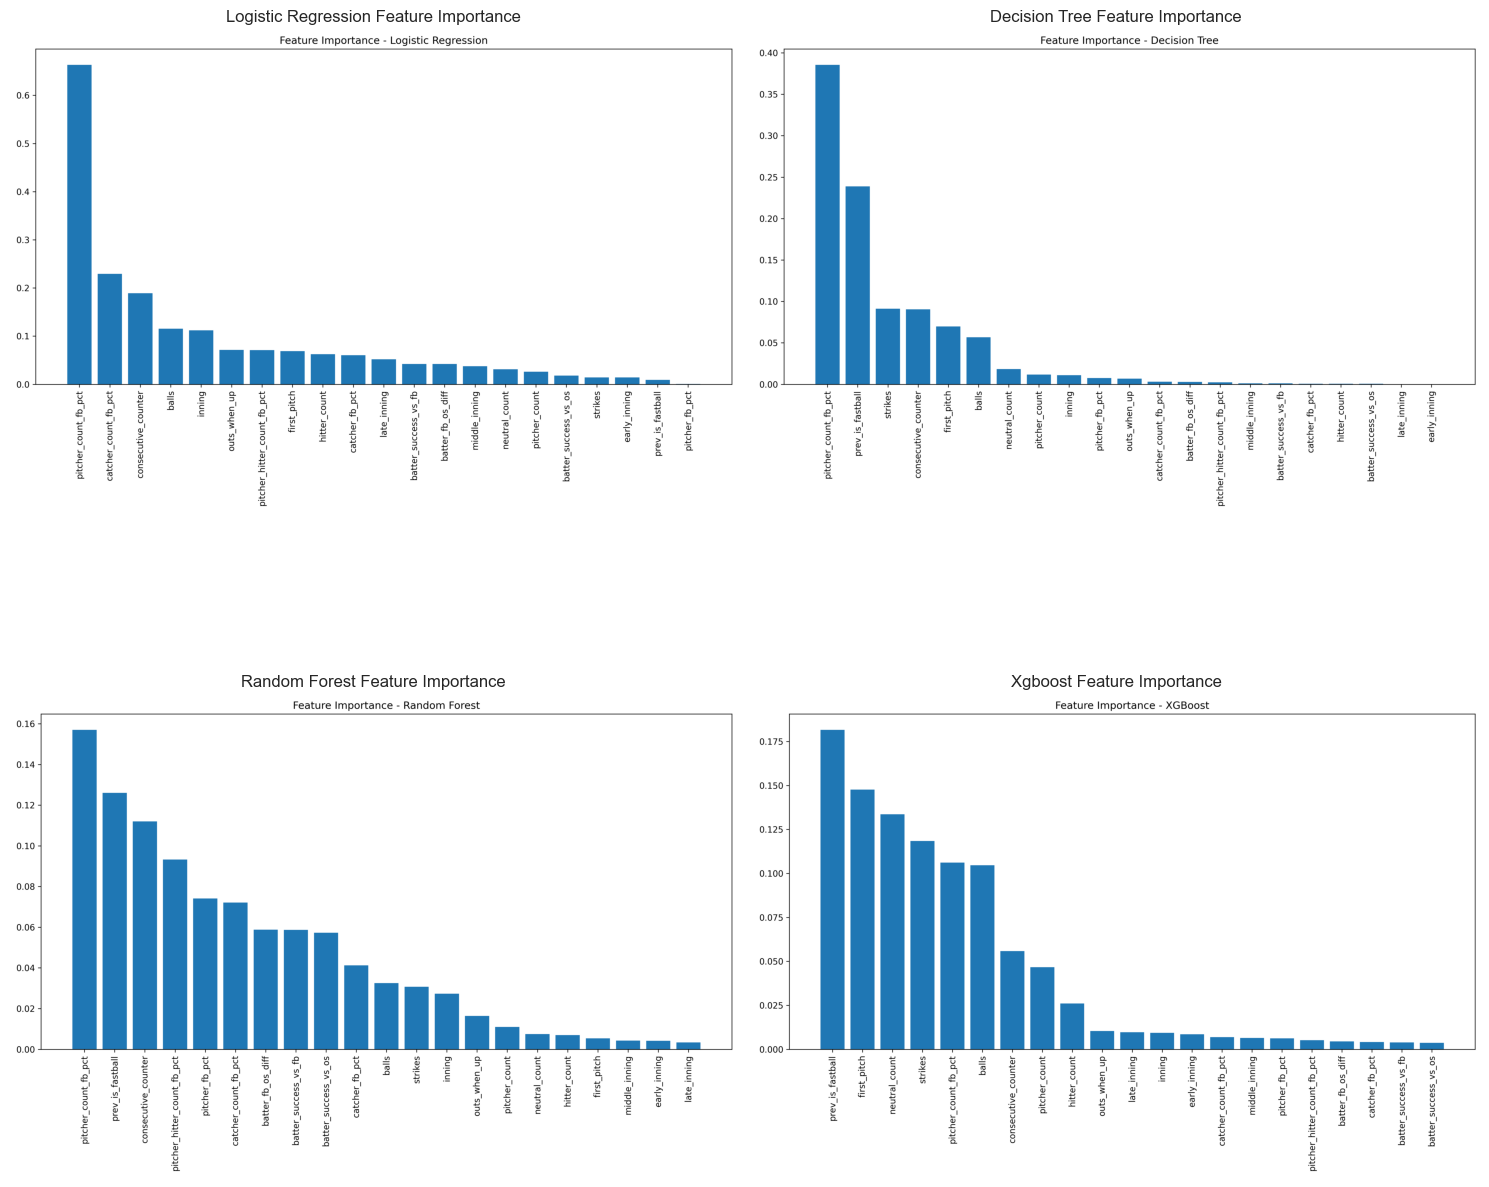

In [7]:
# Load and display feature importance plots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for i, model in enumerate(models):
    img = mpimg.imread(f'../models/results/{model}_feature_importance.png')
    ax = axes[i//2, i%2]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'{model.replace("_", " ").title()} Feature Importance')
plt.tight_layout()

## 5. SHAP Value Analysis

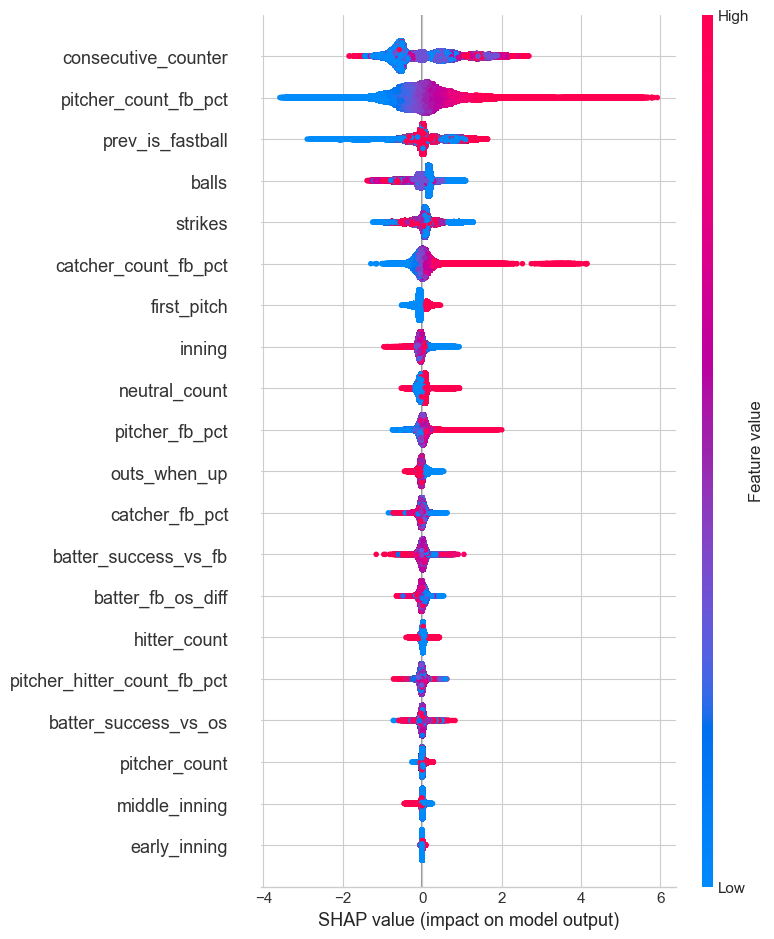

In [12]:
# Load test data and XGBoost model for SHAP analysis
import glob
import os

# Load the most recent XGBoost model
xgb_files = glob.glob('../models/xgboost_*.pkl')
latest_xgb = max(xgb_files, key=os.path.getctime)
with open(latest_xgb, 'rb') as f:
    xgb_model = pickle.load(f)

# Load test data
data = pd.read_csv('../../data/processed/modeling_data_2021_to_2023.csv')
X = data.drop('is_fastball', axis=1)

# Calculate SHAP values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)

# Plot SHAP summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X)

## 6. Model Predictions Analysis

In [ ]:
# Analyze predictions in different game situations
def predict_situation(model, situation_dict):
    # Create a DataFrame with the situation
    situation_df = pd.DataFrame([situation_dict])
    
    # Make prediction
    prob = model.predict_proba(situation_df)[0][1]
    return prob

# Test common situations
situations = [
    {'balls': 0, 'strikes': 0, 'outs_when_up': 0, 'inning': 1, 'pitcher_fb_pct': 0.6},
    {'balls': 3, 'strikes': 2, 'outs_when_up': 2, 'inning': 9, 'pitcher_fb_pct': 0.6},
    {'balls': 0, 'strikes': 2, 'outs_when_up': 1, 'inning': 5, 'pitcher_fb_pct': 0.6}
]

for situation in situations:
    prob = predict_situation(xgb_model, situation)
    print(f"\nSituation: {situation}")
    print(f"Fastball probability: {prob:.3f}")

## 7. Model Calibration Analysis

In [ ]:
# Analyze how well calibrated the model probabilities are
from sklearn.calibration import calibration_curve

y = data['is_fastball']
y_pred = xgb_model.predict_proba(X)[:, 1]

prob_true, prob_pred = calibration_curve(y, y_pred, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Plot')